In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics import Accuracy
from sklearn.metrics import f1_score
import tqdm
import sys
import matplotlib.pyplot as plt
import random

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizza i valori dei pixel
])

transform_test = transforms.Compose([  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizza i valori dei pixel
])

train_folder = './train'
test_folder = './test'

train_dataset = datasets.ImageFolder(train_folder, transform=transform)
test_dataset = datasets.ImageFolder(test_folder, transform=transform_test)

# Plot Dataset

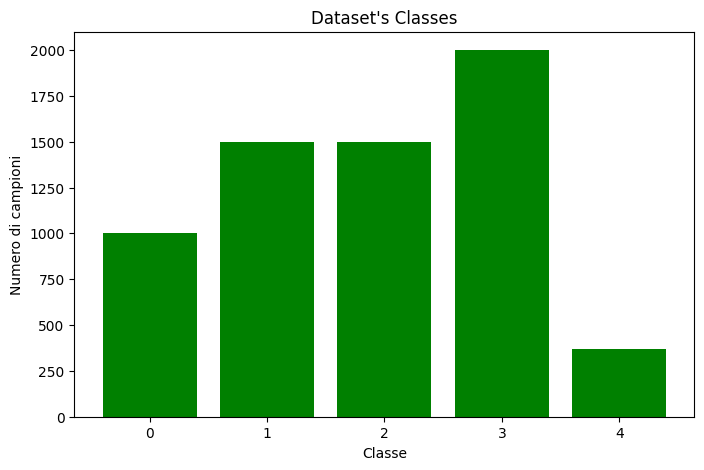

In [3]:
#plot the classes of the datasets
counts_per_class = {}

for _, label in train_dataset:
    if label in counts_per_class:
        counts_per_class[label] += 1
    else:
        counts_per_class[label] = 1

class_labels, counts = zip(*counts_per_class.items())
plt.figure(figsize=(8, 5))
plt.bar(class_labels, counts, color='green')
plt.xlabel('Classe')
plt.ylabel('Numero di campioni')
plt.title('Dataset\'s Classes')
plt.show()

# Data balancing

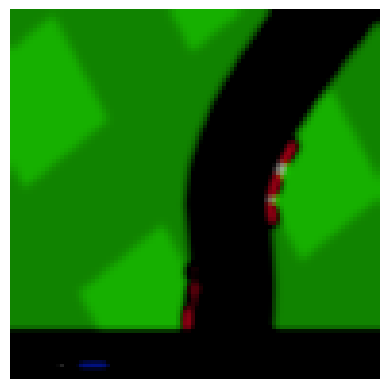

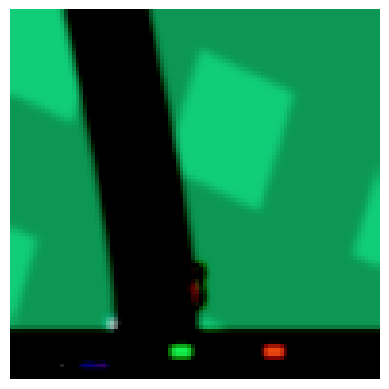

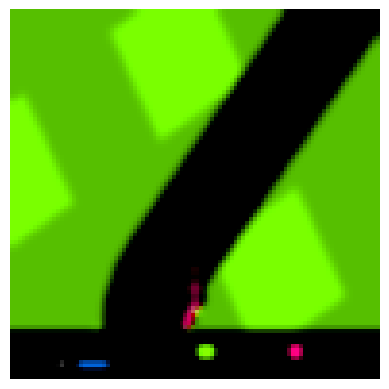

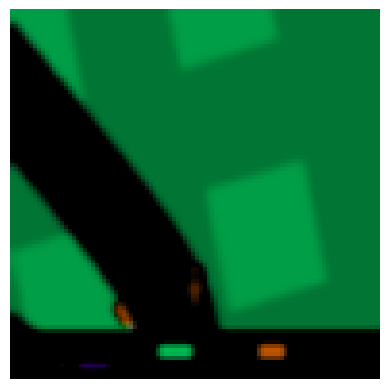

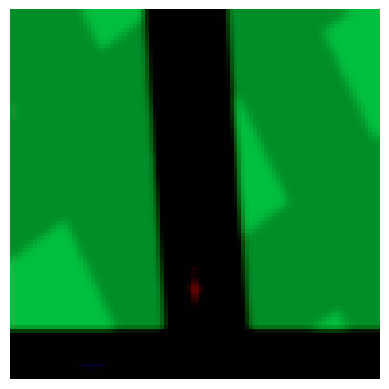

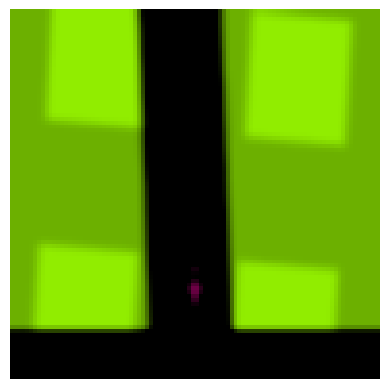

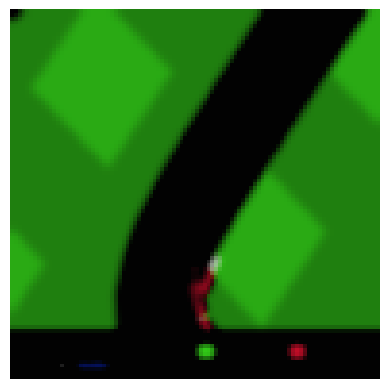

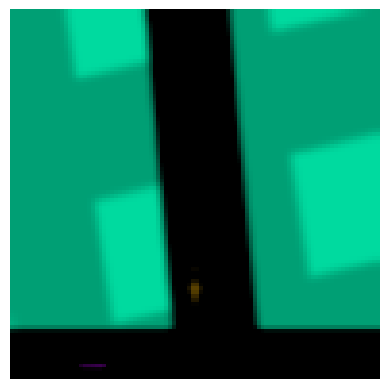

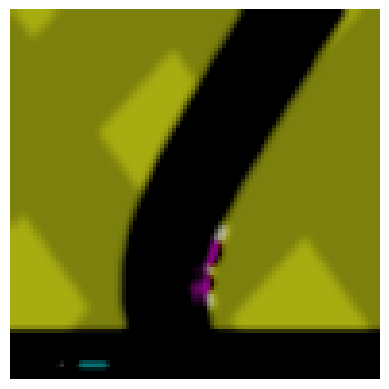

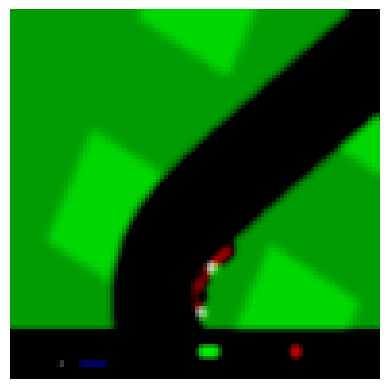

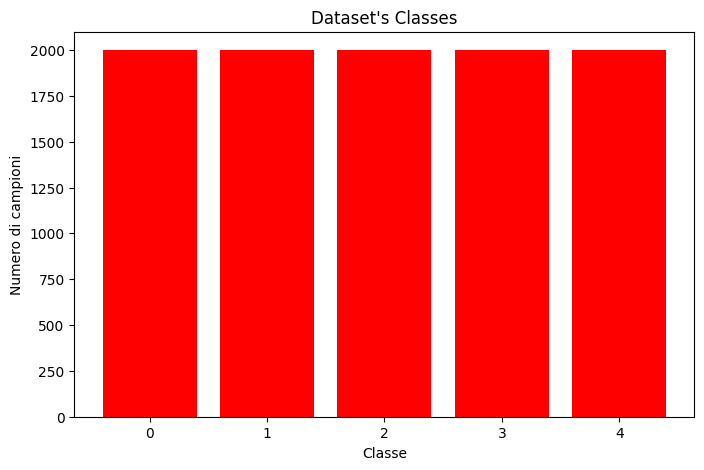

In [4]:
 
counts_per_class = {}

for _, label in train_dataset:
    if label in counts_per_class:
        counts_per_class[label] += 1
    else:
        counts_per_class[label] = 1

data_augmentation_transform = transforms.Compose([
    transforms.Lambda(lambda x: transforms.functional.gaussian_blur(x, kernel_size=5)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  
])

augmented_datasets = []
displayed_images = 0

for class_index in range(5): 
    target_count = max(counts_per_class[class_index], 2000) 

    additional_samples = target_count - counts_per_class[class_index]

    augmented_samples = []
    class_samples = [sample for sample in train_dataset if sample[1] == class_index]

    for _ in range(additional_samples):
        image, label = class_samples[random.randint(0, len(class_samples) - 1)]

        augmented_image = data_augmentation_transform(image)

        if displayed_images < 10:
            plt.imshow(augmented_image.permute(1, 2, 0))
            plt.axis('off')
            plt.show()
            displayed_images += 1

        augmented_samples.append((augmented_image, label))

    counts_per_class[class_index] += additional_samples

    augmented_datasets.extend(augmented_samples)

augmented_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_datasets])

class_labels, counts = zip(*counts_per_class.items())
plt.figure(figsize=(8, 5))
plt.bar(class_labels, counts, color='red')
plt.xlabel('Classe')
plt.ylabel('Numero di campioni')
plt.title('Dataset\'s Classes')
plt.show()

In [11]:
batch_size = 64
train_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(input_channels, 16, 11, padding=2)
        self.conv2 = torch.nn.Conv2d(16, 32, 7, padding=2)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=2)
        self.conv4 = torch.nn.Conv2d(64, 128, 3, padding=2)  

        self.bn1 = torch.nn.BatchNorm2d(16)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.bn4 = torch.nn.BatchNorm2d(128)   

        self.max_pool = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(128*12*12, 50)   
        self.fc2 = torch.nn.Linear(50, 25)
        self.fc3 = torch.nn.Linear(25, 5)
       
        self.drop = torch.nn.Dropout(0.3)



    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.bn1(self.conv1(x)), 0.001)
        x = self.max_pool(x)
        x = torch.nn.functional.leaky_relu(self.bn2(self.conv2(x)), 0.001)
        x = self.max_pool(x)
        x = torch.nn.functional.leaky_relu(self.bn3(self.conv3(x)), 0.001)
        x = torch.nn.functional.leaky_relu(self.bn4(self.conv4(x)), 0.001)   
        x = self.max_pool(x)

        x = x.reshape((-1, 128*12*12))   
        
        x = self.drop(torch.nn.functional.leaky_relu(self.fc1(x), 0.001))
        x = self.fc2(x)
        return self.fc3(x)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn = SimpleCNN().to(device)

In [14]:
def accuracy(cnn, loader, device):
  acc = Accuracy(task='multiclass',num_classes=5).to(device)
  for xb, yb in loader:
      xb, yb = xb.to(device), yb.to(device)
      ypred = cnn(xb)
      _ = acc(ypred, yb)
  return acc.compute()

In [15]:
accuracy(cnn, test_loader, device)
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())


In [16]:
for epoch in range(20):
  
  cnn.train()
  for xb, yb in tqdm.tqdm(train_loader):
    
    xb, yb = xb.to(device), yb.to(device)

    opt.zero_grad()
    ypred = cnn(xb)
    l = loss(ypred, yb)
    l.backward()
    opt.step()

  cnn.eval()
  print(f'Accuracy at epoch {epoch}: {accuracy(cnn, test_loader, device)}')
  #print(f"Test F1 Score: {test_f1}")

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [01:34<00:00,  1.66it/s]


Accuracy at epoch 0: 0.686795175075531


100%|██████████| 157/157 [01:34<00:00,  1.66it/s]


Accuracy at epoch 1: 0.6777009963989258


100%|██████████| 157/157 [01:33<00:00,  1.67it/s]


Accuracy at epoch 2: 0.6405965685844421


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


Accuracy at epoch 3: 0.6540560126304626


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


Accuracy at epoch 4: 0.6409603357315063


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


Accuracy at epoch 5: 0.6791560649871826


100%|██████████| 157/157 [02:18<00:00,  1.13it/s]


Accuracy at epoch 6: 0.6649690866470337


100%|██████████| 157/157 [01:37<00:00,  1.61it/s]


Accuracy at epoch 7: 0.6784285306930542


100%|██████████| 157/157 [01:31<00:00,  1.72it/s]


Accuracy at epoch 8: 0.667151689529419


100%|██████████| 157/157 [01:27<00:00,  1.80it/s]


Accuracy at epoch 9: 0.6442342400550842


100%|██████████| 157/157 [01:28<00:00,  1.77it/s]


Accuracy at epoch 10: 0.6500545740127563


100%|██████████| 157/157 [01:34<00:00,  1.67it/s]


Accuracy at epoch 11: 0.617315411567688


100%|██████████| 157/157 [01:28<00:00,  1.77it/s]


Accuracy at epoch 12: 0.6427791714668274


100%|██████████| 157/157 [01:37<00:00,  1.60it/s]


Accuracy at epoch 13: 0.6613314151763916


100%|██████████| 157/157 [01:39<00:00,  1.58it/s]


Accuracy at epoch 14: 0.6471444368362427


100%|██████████| 157/157 [01:37<00:00,  1.61it/s]


Accuracy at epoch 15: 0.6311386227607727


100%|██████████| 157/157 [01:34<00:00,  1.66it/s]


Accuracy at epoch 16: 0.651145875453949


100%|██████████| 157/157 [01:44<00:00,  1.51it/s]


Accuracy at epoch 17: 0.6074936389923096


100%|██████████| 157/157 [01:39<00:00,  1.58it/s]


Accuracy at epoch 18: 0.64605313539505


100%|██████████| 157/157 [01:36<00:00,  1.62it/s]


Accuracy at epoch 19: 0.599126935005188


In [ ]:

import sys
import torch
import numpy as np
try:
    import gymnasium as gym
except ModuleNotFoundError:
    print('gymnasium module not found. Try to install with')
    print('pip install gymnasium[box2d]')
    sys.exit(1)


def play(env, model):

    seed = 2000
    obs, _ = env.reset(seed=seed)
    
    # drop initial frames
    action0 = 0
    for i in range(50):
        obs,,_,_, = env.step(action0)
    done = False
    while not done:
        obs_torch = torch.from_numpy(obs).float().unsqueeze(0).permute(0, 3, 1, 2)
        p = model(obs_torch) # adapt to your model
        action = np.argmax(p.detach().numpy())  # adapt to your model
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated


env_arguments = {
    'domain_randomize': False,
    'continuous': False,
    'render_mode': 'human'
}

env_name = 'CarRacing-v2'
env = gym.make(env_name, **env_arguments)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)



play(env, cnn)